In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from data_collector import Omie

from potenciala import BucketMethod, Potenciala

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df = pd.read_csv("day_ahead_market_20210706.csv")

In [5]:
p = Potenciala(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)

/Users/malpica/Desktop/projects/electricity/potenciala/metric.py:31: FutureWarning: inplace is deprecated and will be removed in a future version.
  df.columns.set_levels(levels=col_names, level=1, inplace=True)


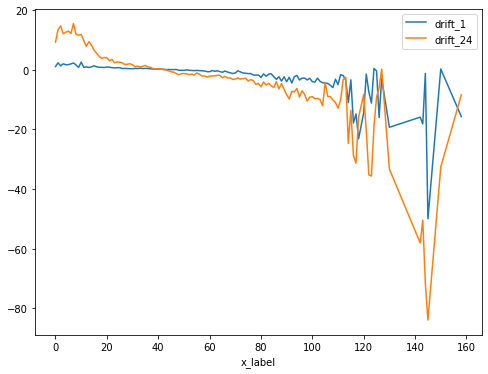

In [6]:
fig, ax = p.drift.plot_mean(series_names=["drift_1", "drift_24"])

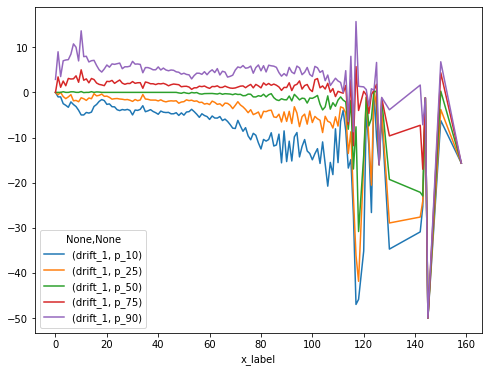

In [7]:
fig, ax = p.drift.plot_percentiles(series_names=["drift_1"])

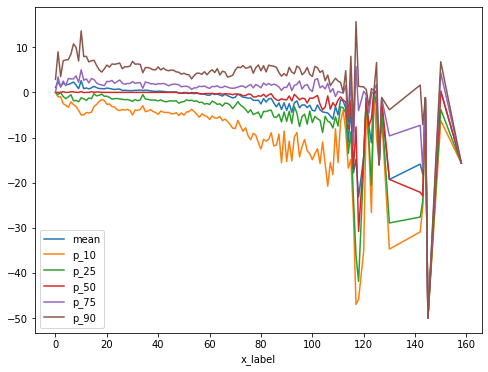

In [8]:
fig, ax = p.drift.plot_mean_percentiles(series_names="drift_1")

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='x_label'>)

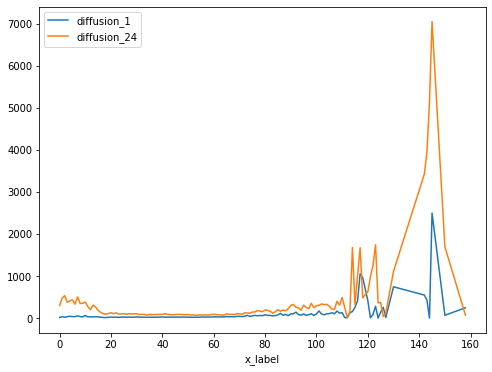

In [13]:
p.diffusion.plot_mean(series_names=["diffusion_1", "diffusion_24"])

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='x_label'>)

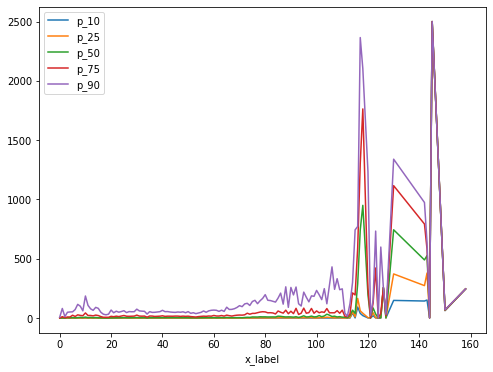

In [16]:
p.diffusion.plot_percentiles(series_names="diffusion_1")

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='x_label'>)

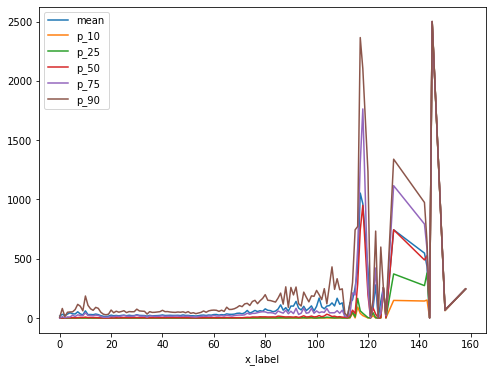

In [20]:
p.diffusion.plot_mean_percentiles(series_names="diffusion_1")

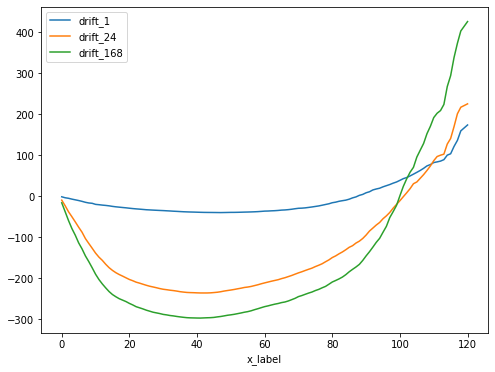

In [25]:
_ = p.potential.iloc[:120].plot()